#Time Series Prediction

##Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats.stats import describe
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Data Exploration

In [2]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRIblPNQb-TaYCVQZDgKTEXPKDvE4Gh7bnXW0lf4rXwYszCTWFQMI85VOZ2qpW31EyH8ufBcAsd7zS5/pub?gid=1736960789&single=true&output=csv'
df = pd.read_csv(url) 
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Years_on_Book,Total_Relationship_Count,Months_Inactive_12_mon,Dates_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,710812533,Attrited Customer,46,F,3,High School,Single,Unknown,Silver,36,3,4,2,17/10/2020,3,34516.0,154,34362.0,0.60,1987,46,0.59,0.00
1,714145233,Attrited Customer,34,M,0,Graduate,Divorced,$80K - $120K,Silver,24,2,1,2,12/10/2020,3,34516.0,400,34116.0,0.20,5112,49,0.26,0.01
2,798022683,Attrited Customer,43,M,1,Graduate,Married,$80K - $120K,Blue,37,3,4,2,30/09/2020,3,25517.0,321,25196.0,0.77,2508,44,0.29,0.01
3,714294183,Attrited Customer,54,M,1,Graduate,Divorced,$80K - $120K,Blue,44,4,1,3,12/09/2020,3,9580.0,132,9448.0,0.32,5385,51,0.31,0.01
4,720815208,Attrited Customer,52,M,0,High School,Single,$120K +,Blue,39,3,5,3,23/09/2020,3,34516.0,216,34300.0,0.56,2395,47,0.31,0.01


In [3]:
df['Dates_Inactive_12_mon'] =  pd.to_datetime(df['Dates_Inactive_12_mon'], infer_datetime_format=True)

In [4]:
df = df[(df.Months_Inactive_12_mon >0)].groupby('Dates_Inactive_12_mon').CLIENTNUM.agg(['count'])
df.head()

,count
Dates_Inactive_12_mon,
2020-05-31,6
2020-06-01,4
2020-06-02,4
2020-06-03,4
2020-06-04,4


###Graph of Inactive VS Count

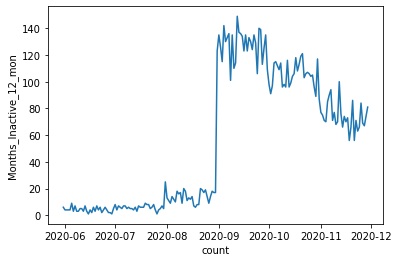

In [5]:
plt.ylabel('Months_Inactive_12_mon')
plt.xlabel('count')
plt.plot(df)
plt.show()

##Time Series Stationary

In [12]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['count'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


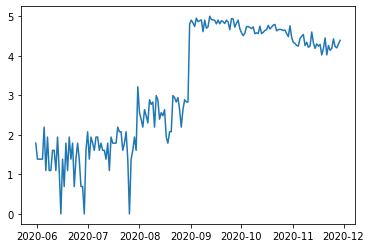

In [13]:
df_log = np.log(df)
plt.plot(df_log)
plt.show()

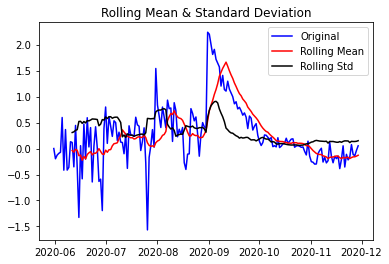

ADF Statistic: -2.5663234725924604
p-value: 0.10015916927400187
Critical Values:
	1%: -3.467845319799907
	5%: -2.878011745497439
	10%: -2.575551186759871


In [14]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

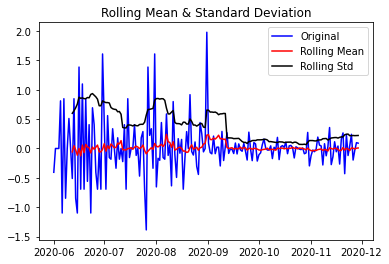

ADF Statistic: -10.507391244636315
p-value: 1.0456748890593551e-18
Critical Values:
	1%: -3.4674201432469816
	5%: -2.877826051844538
	10%: -2.575452082332012


In [15]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

##Creating And Fitting Arima Model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


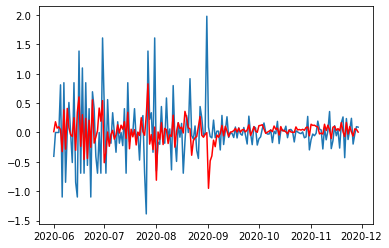

In [16]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.show()

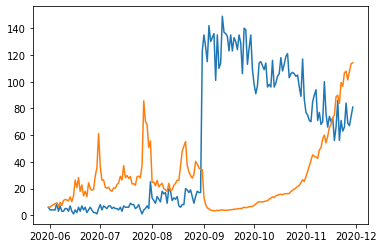

In [17]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['count'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)
plt.show()

##Forecasting Future Churn rate

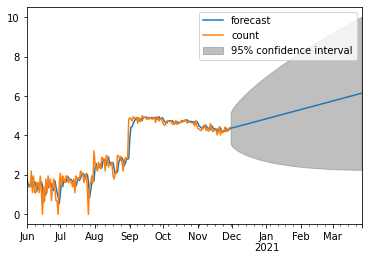

In [19]:
results.plot_predict(1,300)
plt.show()